# Problem description

The majority of available models, trained for object detection and recognition tasks in the field of autonomous/automated driving systems, considers only large objects such as trees on the side of the road, pedestrians, surrounding vehicles, large animals or road blockages.

Detecting small (low-level) obstacles on the road has posed a challenge, mainly due to the noise, or skew, in their pixel frequency or the small size of features that can describe these obstacles relative to the size of the frame. It is difficult for Neural Networks to approximate these type of objects, therefore many times they are randomly classified.

Recently, however, small obstacle detection has gained more popularity as  the demand for fully automated vehicles rose. Detecting unexpected small obstacles on the road could prevent the accidents caused by falling debris, construction activities or lost cargo, etc, providing a safer driving experience.

# About the Dataset

The **Lost and Found** dataset contains images combined with RGB depth information used to segment the image, determining the pixels that belong either to obstacles, road or non-road surfaces. 

The problem with this dataset is that it has a limited depth of 20m and the poor accuracy of detecting very small objects.

The **Small Obstacle Dataset**, created by the Robotics Research Center IIIT from India, collected images as well as sensor data using a highly accurate Lidar sensor, detecting objects up to a depth of 75m. The data between the 2 devices is calibrated in order to obtain a better representation of the driving conditions. The images as well as the sensor data are labeled in order to detect only small level obstacles, which means they are specialized exactly for this type of task.

It consists of 2 sets: one containing data obtained from real-life situations, while the second set contains data from a simulator in Unreal Engine.



### Visualize the data

Start by importing the necessary libraries. The images as well as the point clouds will be plotted using the plotly.matplotlib library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import csv

In [2]:
IMAGE_DIR = "image/"

# ------------------real data-----------------------------
REAL_BASE_PATH = "datasets/small_obs_dataset/Small_Obstacle_Dataset/train/file_1/"
LABELS_DIR = REAL_BASE_PATH + "labels/"
ODOMETRY_DIR = REAL_BASE_PATH + "odometry/"
VELODYNE_DIR = REAL_BASE_PATH + "velodyne/"
CALIBRATION_PATH = REAL_BASE_PATH + "/calibration.txt"

# ---------------synthetic data-----------------------------
SYNTHETIC_BASE_PATH = "datasets/sythetic_sod/synthetic_dataset/train/2019-06-27_14-19-58/"
SEGMENTATION_DIR = SYNTHETIC_BASE_PATH + "segmentation/"
LIDAR_DIR = SYNTHETIC_BASE_PATH + "lidar/"

1. Visualize image data

In [3]:
def view_image_input(image_dir, labels_dir, input_file_name):
    img_path = image_dir + input_file_name
    img = mpimg.imread(img_path)

    segm_path = labels_dir + input_file_name
    segm = mpimg.imread(segm_path)

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 15))

    ax1.set_title("Input image")
    ax1.imshow(img)

    ax2.set_title("Segmentation mask")
    ax2.imshow(segm)

    plt.show(block=True)

Real image sample:


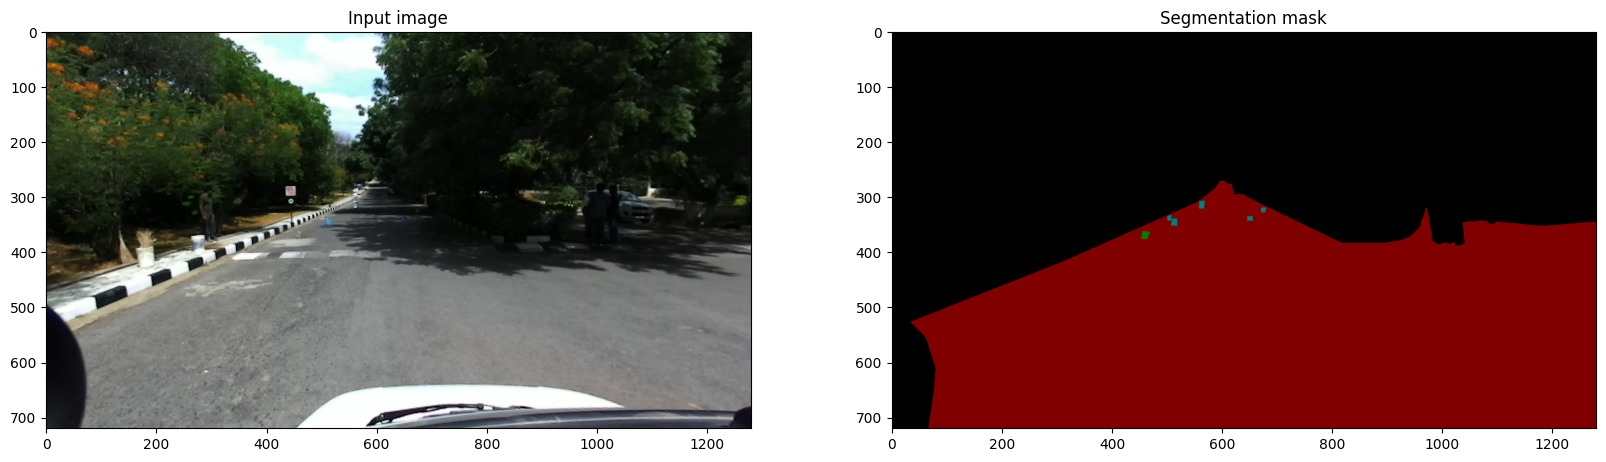

Synthetic image sample:


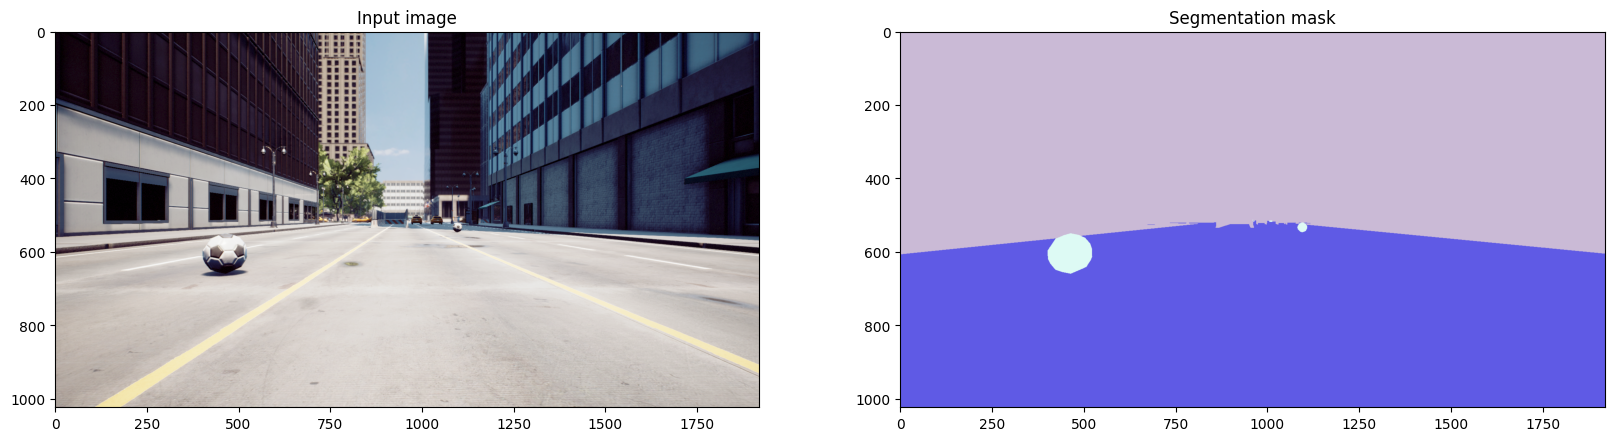

In [11]:
print("Real image sample:")
view_image_input(REAL_BASE_PATH + IMAGE_DIR, LABELS_DIR, "0000000080.png")
print("Synthetic image sample:")
view_image_input(SYNTHETIC_BASE_PATH + IMAGE_DIR, SEGMENTATION_DIR, "21.png")

2. Visualize Lidar data

In [64]:
def camera_transform(points, calibration_file):
    """
    Preprocess lidar points data by applying the transformations after calibrations.
    :param points:
    :param calibration_file:
    :return:
    """
    with open(calibration_file, 'r') as f:
        reader = csv.reader(f)
        coord = []
        for line in reader:
            if len(line) > 0 and len(line[0]) > 0 and line[0][0] != '#':
                # add each line which contains valid numbers (not comments '#' or empty strings ' '
                # remove the last token, which is the empty space at the end of each line
                coord.append(line[0].split(' ')[:-1])
        # convert the string values to float
        coord = np.asarray(coord, 'float64')
        # read 7x4 values, from which:
        ## first 3x4 values belong to the intrinsic camera transformation matrix
        ## last 4x4 values belong to the extrinsic lidar-camera transformation matrix

        coord = np.reshape(coord, (7, 4))
        int_mat = coord[:3]
        ext_mat = coord[3:]

        transform = lambda p, ext_mat, int_mat: int_mat.dot(ext_mat.dot(p))

    return np.array([transform(p, ext_mat, int_mat) for p in points])

In [74]:
def view_lidar_input(base_dir, input_file_name, synthetic=False):
    lidar_path = os.path.join(base_dir, input_file_name)
    pcd = np.load(lidar_path)

    if not synthetic:
        intensities = pcd[:,3]
        pcd = camera_transform(np.delete(pcd, -1, axis=1), CALIBRATION_PATH)

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')
    ax.set_title("Lidar point cloud")
    x = pcd[:,0]
    y = pcd[:,1]
    z = pcd[:,2]
    c = 'blue' if synthetic else intensities
    ax.scatter3D(x, y, z, c=c, linewidth=0.3)
    plt.show()

Real Lidar point-cloud sample:


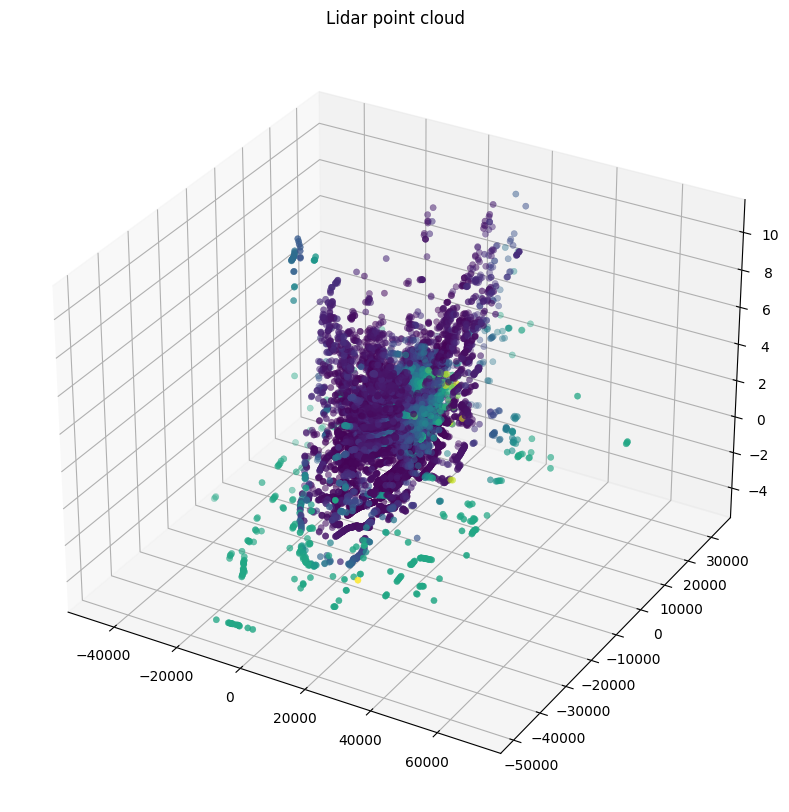

Synthetic Lidar point-cloud sample:


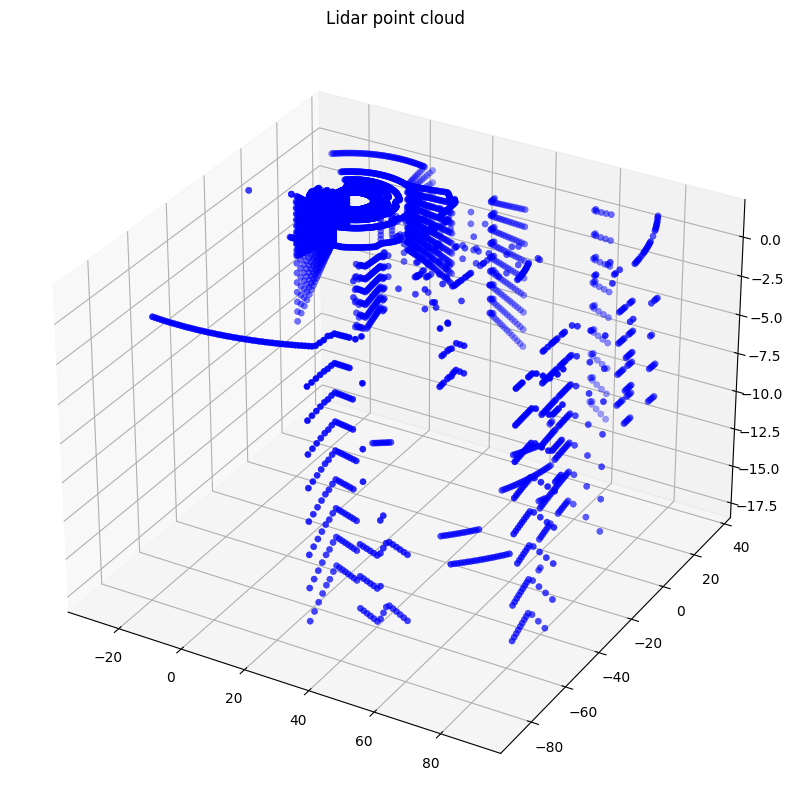

In [75]:
print("Real Lidar point-cloud sample:")
view_lidar_input(VELODYNE_DIR, "0000000080.npy")
print("Synthetic Lidar point-cloud sample:")
view_lidar_input(LIDAR_DIR, "21.npy", synthetic=True)